# <span style="font-width:bold; font-size: 3rem; color:#2656a3;">**Msc. BDS - M7 Second Semester Project** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 03: Training Pipeline</span>

## <span style='color:#2656a3'> 🗒️ This notebook is divided into the following sections:
1. Feature selection.
2. Creating a Feature View.
3. Training datasets creation - splitting into train and test sets.
4. Training the model.
5. Register the model to Hopsworks Model Registry.

## <span style='color:#2656a3'> ⚙️ Import of libraries and packages
We start with importing some of the necessary libraries needed for this notebook and warnings to avoid unnecessary distractions and keep output clean.

In [1]:
# Importing the packages and libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

## <span style="color:#2656a3;"> 📡 Connecting to Hopsworks Feature Store
We connect to Hopsworks Feature Store so we can retrieve the Feature Groups and select features for training data.

In [2]:
# Importing the hopsworks module for interacting with the Hopsworks platform
import hopsworks

# Logging into the Hopsworks project
project = hopsworks.login()

# Getting the feature store from the project
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/556180
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# Retrieve the feature groups
electricity_fg = fs.get_feature_group(
    name='electricity_prices',
    version=1,
)

electricity_price_window_fg = fs.get_feature_group(
    name='electricity_price_window',
    version=1,
)

weather_fg = fs.get_feature_group(
    name='weather_measurements',
    version=1,
)

danish_calendar_fg = fs.get_feature_group(
    name='dk_calendar',
    version=1,
)

## <span style="color:#2656a3;"> 🖍 Feature View Creation and Retrieving </span>

We first select the features that we want to include for model training.

Since we specified `primary_key`as `date` and `timestamp` in `1_feature_backfill` we can now join them together for the `electricity_fg`, `weather_fg` and `danish_holiday_fg`.

`join_type` specifies the type of join to perform. An inner join refers to only retaining the rows based on the keys present in all joined DataFrames.

In [9]:
# Select features for training data and join them together and except duplicate columns
selected_features = electricity_fg.select_all()\
    .join(weather_fg.select_except(["timestamp", "datetime", "hour", "date"]), join_type="inner")\
    .join(danish_calendar_fg.select_except(["timestamp", "datetime", "hour", "date"]), join_type="inner")

In [ ]:
# transformation_functions = {
#         "hour": fs.get_transformation_function(name="min_max_scaler"),
#         "dk1_spotpricedkk_kwh": fs.get_transformation_function(name="min_max_scaler"),
#         "temperature_2m": fs.get_transformation_function(name="min_max_scaler"),
#         "relative_humidity_2m": fs.get_transformation_function(name="min_max_scaler"),
#         "precipitation": fs.get_transformation_function(name="min_max_scaler"),
#         "rain": fs.get_transformation_function(name="min_max_scaler"),
#         "snowfall": fs.get_transformation_function(name="min_max_scaler"),
#         "weather_code": fs.get_transformation_function(name="min_max_scaler"),
#         "cloud_cover": fs.get_transformation_function(name="min_max_scaler"),
#         "wind_speed_10m": fs.get_transformation_function(name="min_max_scaler"),
#         "wind_gusts_10m": fs.get_transformation_function(name="min_max_scaler"),
#         "dayofweek": fs.get_transformation_function(name="min_max_scaler"),
#         "day": fs.get_transformation_function(name="min_max_scaler"),
#         "month": fs.get_transformation_function(name="min_max_scaler"),
#         "year": fs.get_transformation_function(name="min_max_scaler"),
#         "workday": fs.get_transformation_function(name="min_max_scaler"),
#     }


In [10]:
# Display the first 5 rows of the selected features
selected_features.show(5)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.83s) 


,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
0,1688745600000,2023-07-07 16:00:00+00:00,2023-07-07 00:00:00+00:00,16,0.59802,20.3,57.0,0.0,0.0,0.0,0.0,17.0,17.4,35.3,4,7,7,2023,1
1,1660867200000,2022-08-19 00:00:00+00:00,2022-08-19 00:00:00+00:00,0,3.79462,12.8,95.0,0.0,0.0,0.0,1.0,26.0,4.2,13.3,4,19,8,2022,1
2,1673035200000,2023-01-06 20:00:00+00:00,2023-01-06 00:00:00+00:00,20,1.03449,6.0,90.0,0.4,0.4,0.0,51.0,74.0,17.9,34.2,4,6,1,2023,1
3,1681880400000,2023-04-19 05:00:00+00:00,2023-04-19 00:00:00+00:00,5,0.78883,5.3,77.0,0.0,0.0,0.0,0.0,0.0,12.7,22.3,2,19,4,2023,1
4,1714208400000,2024-04-27 09:00:00+00:00,2024-04-27 00:00:00+00:00,9,0.44051,7.4,74.0,0.1,0.1,0.0,51.0,90.0,5.4,16.6,5,27,4,2024,0


A `Feature View` stands between the **Feature Groups** and **Training Dataset**. Сombining **Feature Groups** we can create a **Feature View** which stores a metadata of our data. Having the **Feature View** we can create a **Training Dataset**.

In order to create Feature View we can use `fs.get_or_create_feature_view()` method.

We can specify parameters:

- `name` - Name of the feature view to create.
- `version` - Version of the feature view to create.
- `query` - Query object with the data.

In [11]:
# Getting or creating a feature view named 'electricity_price_feature_view'
version=1
feature_view_training = fs.get_or_create_feature_view(
    name='lstm_electricity_price_feature_view',
    version=version,
    query=selected_features,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/556180/fs/552003/fv/lstm_electricity_price_feature_view/version/1


In [ ]:
# # Getting or creating a feature view named 'dk1_electricity_training_feature_view'
# version = 1
# feature_view_training = fs.get_or_create_feature_view(
#     name='lstm_dk1_electricity_training_feature_view',
#     version=version,
#     transformation_functions=transformation_functions,
#     query=selected_features_training,
# )

## <span style="color:#2656a3;"> 🏋️ Training Dataset Creation</span>

In Hopsworks, a training dataset is generated from a query defined by the parent FeatureView, which determines the set of features.

**Training Dataset may contain splits such as:** 
* Training set: This subset of the training data is utilized for model training.
* Validation set: Used for evaluating hyperparameters during model training. *(We have not included a validation set for this project)*
* Test set: Reserved as a holdout subset of training data for evaluating a trained model's performance.

Training dataset is created using `fs.training_data()` method.

In [12]:
# Retrieve training data from the feature view 'feature_view_training', assigning the features to 'X'.
df, _ = feature_view_training.training_data(
    description = 'LSTM Electricity Prices Training Dataset',
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.74s) 
2024-05-23 19:53:55,428 WARNING: VersionWarning: Incremented version to `1`.



In [13]:
# sort the data by timestamp and reset the index for time series data
df.sort_values(by='timestamp', ascending=True, inplace=True)
df = df.reset_index(drop=True)

df.head()

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
0,1640995200000,2022-01-01 00:00:00+00:00,2022-01-01 00:00:00+00:00,0,0.37220,6.7,100.0,0.0,0.0,0.0,3.0,100.0,16.2,36.0,5,1,1,2022,0
1,1640998800000,2022-01-01 01:00:00+00:00,2022-01-01 00:00:00+00:00,1,0.30735,6.6,100.0,0.0,0.0,0.0,3.0,100.0,16.2,30.2,5,1,1,2022,0
2,1641002400000,2022-01-01 02:00:00+00:00,2022-01-01 00:00:00+00:00,2,0.32141,6.7,99.0,0.0,0.0,0.0,3.0,100.0,15.5,30.6,5,1,1,2022,0
3,1641006000000,2022-01-01 03:00:00+00:00,2022-01-01 00:00:00+00:00,3,0.33806,6.7,100.0,0.0,0.0,0.0,3.0,100.0,12.7,28.8,5,1,1,2022,0
4,1641009600000,2022-01-01 04:00:00+00:00,2022-01-01 00:00:00+00:00,4,0.28013,6.7,99.0,0.0,0.0,0.0,3.0,100.0,10.6,23.8,5,1,1,2022,0


## <span style="color:#2656a3;">🧬 Modeling</span>

### <span style="color:#2656a3;">🧬 Model 1: Random Train/Test Split LSTM Model</span>

#### <span style="color:#2656a3;">👆 Feature Selection</span>

In [14]:
# Select features and target
features = df.drop(columns=['dk1_spotpricedkk_kwh','datetime','date','timestamp'])
target = df['dk1_spotpricedkk_kwh']

# Normalize the features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Normalize the target
target = target.values.reshape(-1, 1)
target_scaler = MinMaxScaler()
target_scaled = target_scaler.fit_transform(target)

# Convert back to DataFrame for easier handling
features_scaled = pd.DataFrame(features_scaled, index=features.index, columns=features.columns)
target_scaled = pd.DataFrame(target_scaled, index=features.index, columns=['dk1_spotpricedkk_kwh'])

#### <span style="color:#2656a3;"> ⛳️ Dataset with train and test splits</span>

Here we define our train and test splits for traning the model.

Create Sequences for X and y

In [15]:
from sklearn.model_selection import train_test_split

def create_sequences(features, target, time_steps=24):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features.iloc[i:i+time_steps].values)
        y.append(target.iloc[i+time_steps].values)
    return np.array(X), np.array(y)

time_steps = 24  # Use the past 24 hours to predict the next hour
X, y = create_sequences(features_scaled, target_scaled, time_steps)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### <span style="color:#2656a3;">🏠 Model Building</span>

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])), # Set to True for multiple LSTM layers
    LSTM(50, return_sequences=False), # Set to False for the last LSTM layer
    Dense(1) # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')



#### <span style="color:#2656a3;">💪 Model Training</span>

In [17]:
# Train the model
history = model.fit(X_train, y_train, epochs=12, batch_size=32, validation_data=(X_test, y_test)) # Increase epochs for better performance

Epoch 1/12
524/524 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0144 - val_loss: 0.0035
Epoch 2/12
524/524 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 3/12
524/524 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 4/12
524/524 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 5/12
524/524 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 6/12
524/524 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/12
524/524 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 8/12
524/524 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 9/12
524/524 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/12
524/524 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 11/12
524/524 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 12/12
524/524 ━━━━━━━━━━━━━━━━━━━━ 5s

#### <span style='color:#2656a3'> ⚖️ Model Validation

In [18]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011
Test Loss: 0.0011191876837983727


In [19]:
# Predict on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and the true values to their original scale
y_pred_inverse = target_scaler.inverse_transform(y_pred)
y_test_inverse = target_scaler.inverse_transform(y_test)

# Calculate performance metrics (e.g., RMSE)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Calculate performance metrics

rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
r2 = r2_score(y_test_inverse, y_pred_inverse)

print(f'RMSE: {np.sqrt(rmse)}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
RMSE: 0.5712857291606516
MAE: 0.22936469749025595
MSE: 0.10651566956264172
R²: 0.8668513817843808


2024-05-23 19:56:32,417 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



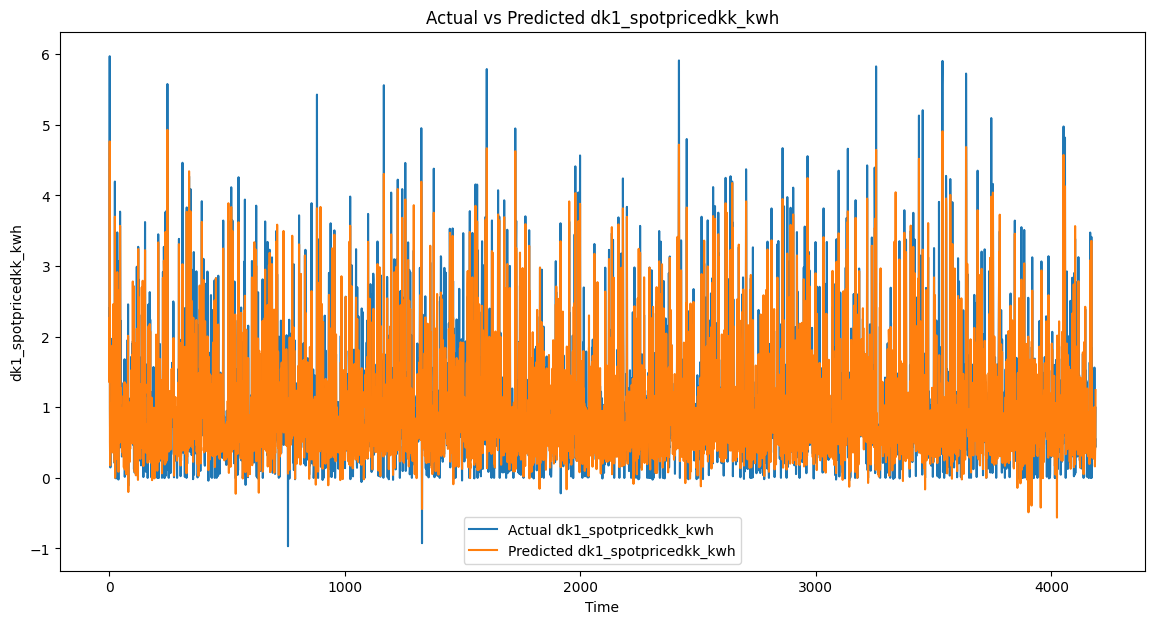

In [20]:
import matplotlib.pyplot as plt

# Plotting the true values and the predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual dk1_spotpricedkk_kwh')
plt.plot(y_pred_inverse, label='Predicted dk1_spotpricedkk_kwh')
plt.title('Actual vs Predicted dk1_spotpricedkk_kwh')
plt.xlabel('Time')
plt.ylabel('dk1_spotpricedkk_kwh')
plt.legend()
plt.show()

#### Feature Importance

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


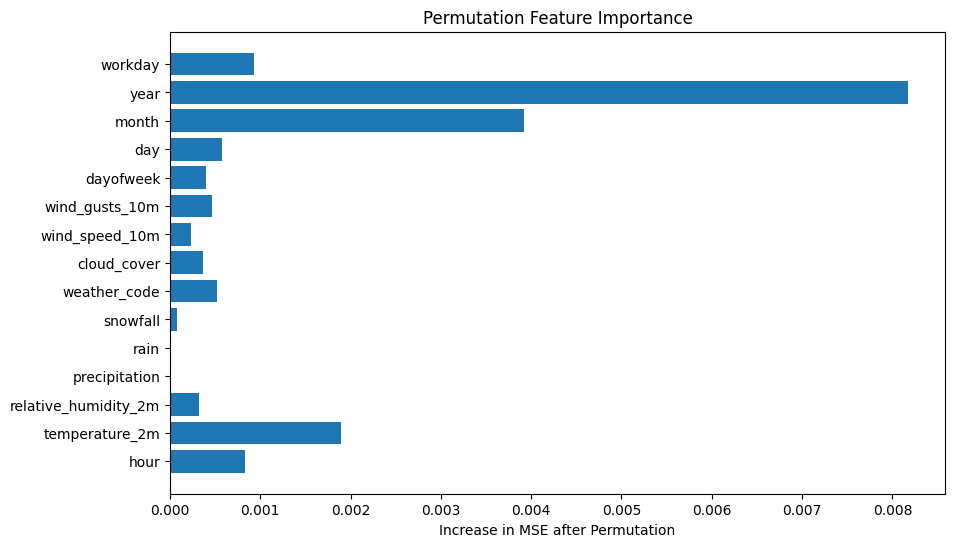

In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to calculate permutation feature importance
def permutation_feature_importance(model, X_val, y_val, feature_names):
    baseline_mse = mean_squared_error(y_val, model.predict(X_val))
    importances = []

    for col in range(X_val.shape[2]):
        X_val_permuted = np.copy(X_val)
        np.random.shuffle(X_val_permuted[:, :, col])
        permuted_mse = mean_squared_error(y_val, model.predict(X_val_permuted))
        importances.append(permuted_mse - baseline_mse)

    return np.array(importances), feature_names

# Calculate feature importance
importances, feature_names = permutation_feature_importance(model, X_test, y_test, features.columns)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), feature_names)
plt.xlabel('Increase in MSE after Permutation')
plt.title('Permutation Feature Importance')
plt.show()

#### <span style="color:#2656a3;">🤖 Making the predictions</span>

In [22]:
# Extract the last 5 predictions and their corresponding actual values
last_5_predictions = y_pred_inverse[-5:]
last_5_actuals = y_test_inverse[-5:]

# Print the last 5 predictions and their actual values
print("Last 5 Predictions vs Actual Values:")
for i in range(5):
    print(f"Prediction: {last_5_predictions[i][0]:.4f}, Actual: {last_5_actuals[i][0]:.4f}")

Last 5 Predictions vs Actual Values:
Prediction: 0.8501, Actual: 0.9978
Prediction: 0.1625, Actual: 0.4646
Prediction: 0.3843, Actual: 0.5592
Prediction: 0.4415, Actual: 0.4333
Prediction: 1.2433, Actual: 0.9935


### <span style="color:#2656a3;">🧬 Model 2: Temporal LSTM model</span>

#### Preprocess the Data

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming your DataFrame is named df


# Selecting the relevant features and target
features = df.drop(columns=['dk1_spotpricedkk_kwh','datetime','date','timestamp'])

target = df['dk1_spotpricedkk_kwh'].values.reshape(-1, 1)

# Scaling the features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target)


#### Create Sequences

In [24]:
def create_sequences(features, target, time_steps=24):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 24  # For hourly data, 24 time steps correspond to one day
X, y = create_sequences(features_scaled, target_scaled, time_steps)

#### <span style="color:#2656a3;"> ⛳️ Dataset with train and test splits</span>

Here we define our train and test splits for traning the model.

In [25]:
# Train-test split
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

#### <span style="color:#2656a3;">🏠 Model Building</span>

In [26]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

#### <span style="color:#2656a3;">💪 Model Training</span>

In [27]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0097 - val_loss: 0.0013
Epoch 2/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 3/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 4/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 5/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 6/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 8/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 9/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 10/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 11/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 12/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 

#### <span style='color:#2656a3'> ⚖️ Model Validation

In [29]:
# Predict on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and the true values to their original scale
y_pred_inverse = scaler_target.inverse_transform(y_pred)
y_test_inverse = scaler_target.inverse_transform(y_test)

# Calculate performance metrics (e.g., RMSE)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Calculate performance metrics

loss = model.evaluate(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
r2 = r2_score(y_test_inverse, y_pred_inverse)

print(f'Val Loss: {loss}')
print(f'RMSE: {np.sqrt(rmse)}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R2: {r2}')

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
RMSE: 0.49474678300801955
MAE: 0.17978013819954033
MSE: 0.05991449676012605
R2: 0.05359774445127519


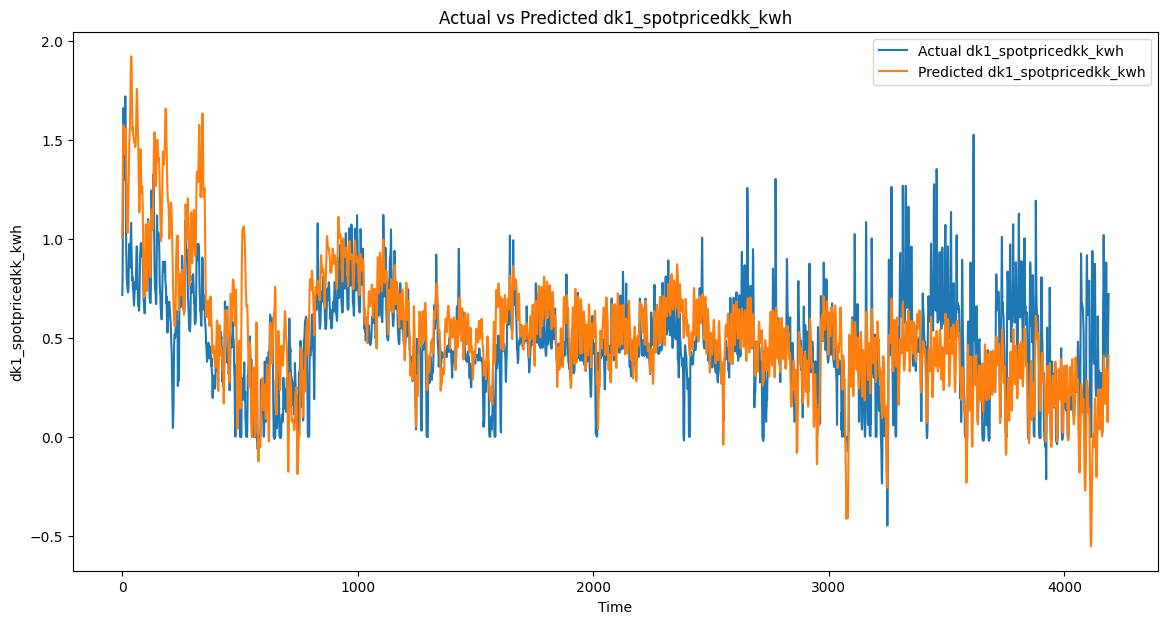

In [30]:
import matplotlib.pyplot as plt

# Plotting the true values and the predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual dk1_spotpricedkk_kwh')
plt.plot(y_pred_inverse, label='Predicted dk1_spotpricedkk_kwh')
plt.title('Actual vs Predicted dk1_spotpricedkk_kwh')
plt.xlabel('Time')
plt.ylabel('dk1_spotpricedkk_kwh')
plt.legend()
plt.show()

#### Feature Importance

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


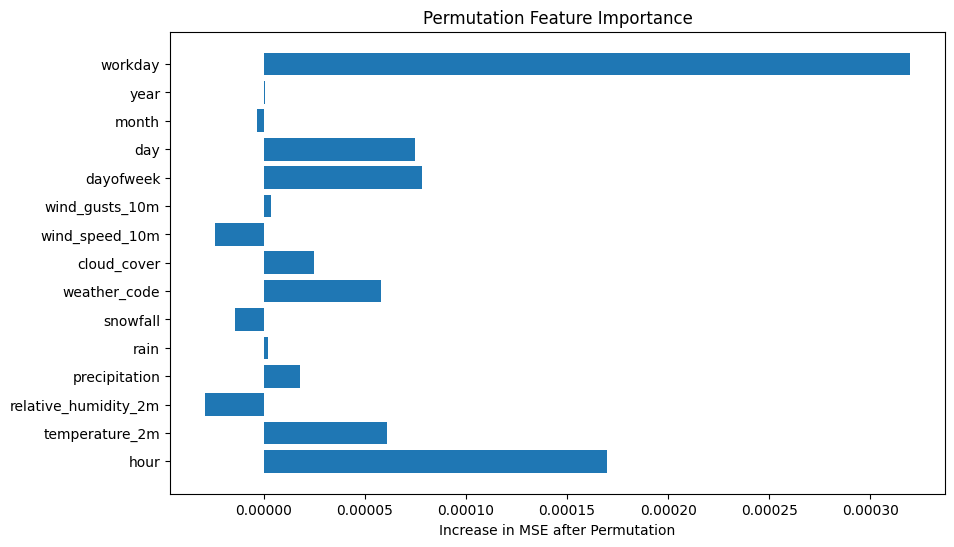

In [31]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to calculate permutation feature importance
def permutation_feature_importance(model, X_val, y_val, feature_names):
    baseline_mse = mean_squared_error(y_val, model.predict(X_val))
    importances = []

    for col in range(X_val.shape[2]):
        X_val_permuted = np.copy(X_val)
        np.random.shuffle(X_val_permuted[:, :, col])
        permuted_mse = mean_squared_error(y_val, model.predict(X_val_permuted))
        importances.append(permuted_mse - baseline_mse)

    return np.array(importances), feature_names

# Calculate feature importance
importances, feature_names = permutation_feature_importance(model, X_test, y_test, features.columns)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), feature_names)
plt.xlabel('Increase in MSE after Permutation')
plt.title('Permutation Feature Importance')
plt.show()

#### <span style="color:#2656a3;">🤖 Making the predictions</span>

In [33]:
# Extract the last 5 predictions and their corresponding actual values
last_5_predictions = y_pred_inverse[-5:]
last_5_actuals = y_test_inverse[-5:]

# Print the last 5 predictions and their actual values
print("Last 5 Predictions vs Actual Values:")
for i in range(5):
    print(f"Prediction: {last_5_predictions[i][0]:.4f}, Actual: {last_5_actuals[i][0]:.4f}")

Last 5 Predictions vs Actual Values:
Prediction: 0.0754, Actual: 0.3381
Prediction: 0.1274, Actual: 0.4252
Prediction: 0.2092, Actual: 0.5328
Prediction: 0.3111, Actual: 0.6251
Prediction: 0.4122, Actual: 0.7211


### <span style="color:#2656a3;">🧬 Model 3: Hybrid Conv1D-Bidirectional LSTM Time Series Model</span>

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, BatchNormalization, LeakyReLU, MaxPooling1D, Bidirectional, Dropout

def build_model(input_dim):
    # Creating a Sequential model
    model = Sequential()

    # Adding a 1D convolutional layer
    model.add(Conv1D(filters=64, # Number of filters for the convolutional layer
                     kernel_size=1, # kernel size to detect patterns over short periods.
                     padding='same', # padding to ensure the output has the same length as the input
                     kernel_initializer="uniform", # kernel initializer
                     input_shape=(input_dim[0], input_dim[1]))) # input shape
    model.add(BatchNormalization()) # normalize the activations of the previous layer at each batch
    model.add(LeakyReLU(alpha=0.2)) #  type of activation function based on a ReLU, but it has a small slope for negative values instead of a flat slope.

    # Adding 1D convolutional layer
    model.add(Conv1D(filters=32, # smaller number of filters for
                     kernel_size=1, 
                     padding='same', 
                     kernel_initializer="uniform"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) # alpha 0.2 that is used to control the amount of leakage

    # Adding 1D convolutional layer
    model.add(Conv1D(filters=16, 
                     kernel_size=1, 
                     padding='same', 
                     kernel_initializer="uniform"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # Adding a 1D max pooling layer
    model.add(MaxPooling1D(pool_size=1, padding='same')) # max pooling layer to downsample the input representation

    # Adding a Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=50, return_sequences=True))) # Bidirectional layer to learn from the input sequence in both forward and backward directions
    model.add(Dropout(rate=0.1))

    # Adding a second LSTM layer
    model.add(LSTM(units=50, return_sequences=False))
    
    # Adding a Dense layer with 1 unit for the output
    model.add(Dense(units=1))  # Output layer

    # Displaying the model summary
    model.summary()

    # Compiling the model with mean squared error loss and the Adam optimizer
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

#### Create Sequences

In [72]:
def create_sequences(features, target, time_steps=24):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 24  # For hourly data, 24 time steps correspond to one day
X, y = create_sequences(features_scaled, target_scaled, time_steps)

#### <span style="color:#2656a3;"> ⛳️ Dataset with train and test splits</span>

Here we define our train and test splits for traning the model.

In [73]:
# Train-test split
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

#### <span style="color:#2656a3;">🏠 Model Building</span>

In [74]:
# input_dim
input_dim = (X_train.shape[1], X_train.shape[2]) # sequence_length, num_features
model = build_model(input_dim) 

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 24, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 24, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 24, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 24, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 24, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 24, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 24, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 24, 100)        │        26,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,131 (238.79 KB)

 Trainable params: 60,907 (237.92 KB)

 Non-trainable params: 224 (896.00 B)

#### <span style="color:#2656a3;">💪 Model Training</span>

In [86]:
# Train the model
# history for the loss function and the validation loss function
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test)) 

Epoch 1/10


524/524 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 7.5534e-04 - val_loss: 0.0014
Epoch 2/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 7.6183e-04 - val_loss: 0.0010
Epoch 3/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 7.2247e-04 - val_loss: 0.0010
Epoch 4/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 6.8319e-04 - val_loss: 5.0026e-04
Epoch 5/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 6.4121e-04 - val_loss: 4.7658e-04
Epoch 6/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 6.8501e-04 - val_loss: 8.2781e-04
Epoch 7/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 5.9403e-04 - val_loss: 9.0123e-04
Epoch 8/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 6.8002e-04 - val_loss: 0.0010
Epoch 9/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 5.7809e-04 - val_loss: 6.2674e-04
Epoch 10/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 5.5433e-04 - val_loss: 6.8142e-04


In [87]:
# Extracting the training history dictionary from the model training
history_dict = history.history

# Displaying the keys in the history dictionary
print(history_dict.keys())

dict_keys(['loss', 'val_loss'])


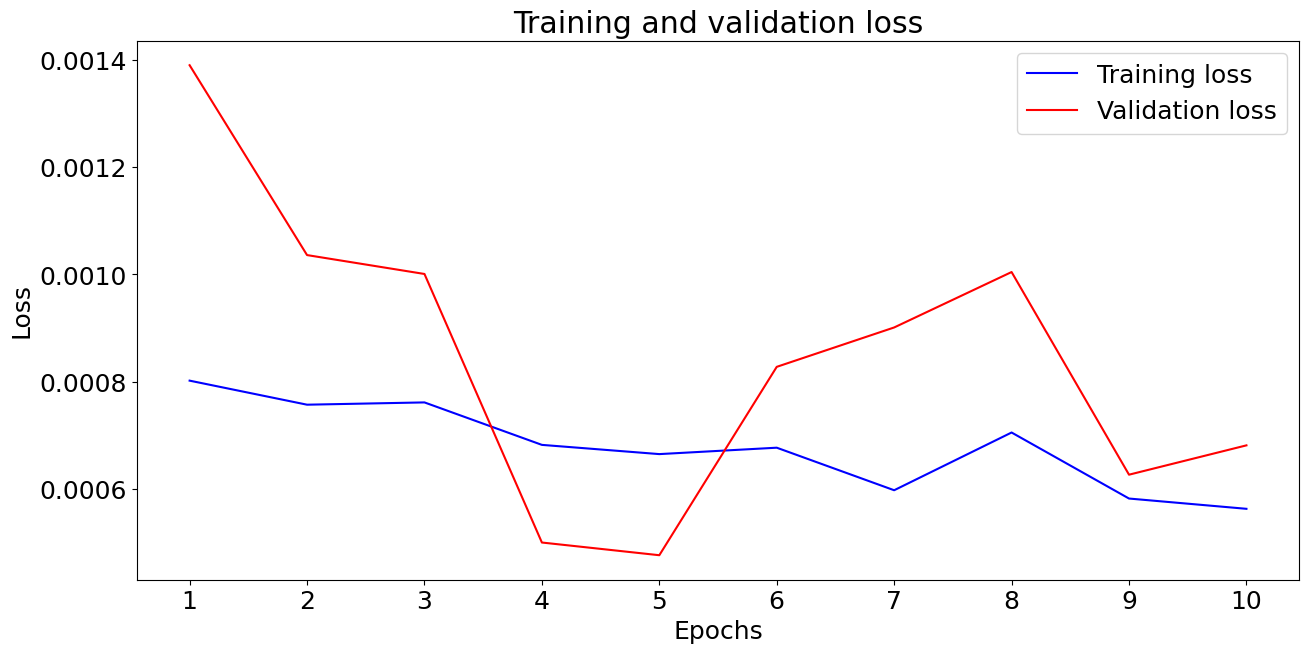

In [88]:
# Extracting training and validation loss values from the history dictionary
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Creating separate variables for loss values (50 epochs)
loss_values50 = loss_values
val_loss_values50 = val_loss_values

# Generating a plot for training and validation loss over epochs
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, 'b', color='blue', label='Training loss')
plt.plot(epochs, val_loss_values50, 'b', color='red', label='Validation loss')

# Setting plot details and labels
plt.rc('font', size=18)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)

# Adjusting the size of the plot
fig = plt.gcf()
fig.set_size_inches(15, 7)

# Displaying the plot
plt.show()

In [89]:
# Predict on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and the true values to their original scale
y_pred_inverse = scaler_target.inverse_transform(y_pred)
y_test_inverse = scaler_target.inverse_transform(y_test)

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


#### <span style="color:#2656a3;">🤖 Making the predictions</span>

In [96]:
# Extract the last 5 predictions and their corresponding actual values
last_5_predictions = y_pred_inverse[-5:]
last_5_actuals = y_test_inverse[-5:]

# Print the last 5 predictions and their actual values
print("Last 5 Predictions vs Actual Values:")
for i in range(5):
    print(f"Prediction: {last_5_predictions[i][0]:.4f}, Actual: {last_5_actuals[i][0]:.4f}")

Last 5 Predictions vs Actual Values:
Prediction: 0.6494, Actual: 0.3381
Prediction: 0.6738, Actual: 0.4252
Prediction: 0.7180, Actual: 0.5328
Prediction: 0.9024, Actual: 0.6251
Prediction: 1.0379, Actual: 0.7211


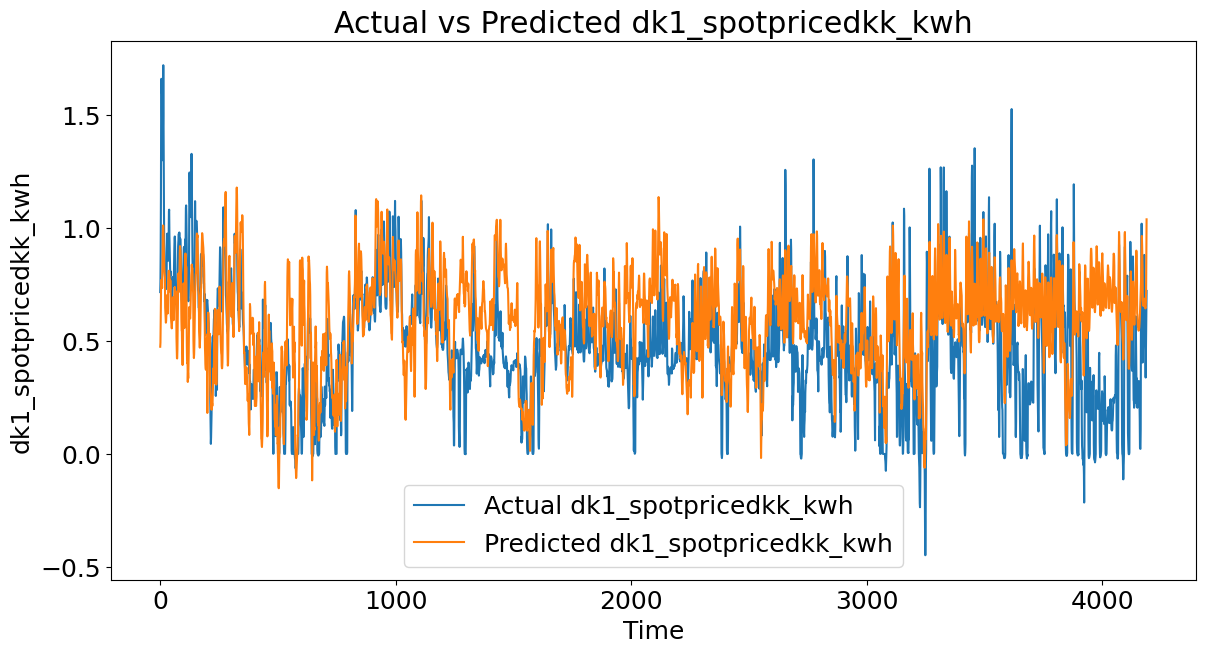

In [90]:
import matplotlib.pyplot as plt

# Plotting the true values and the predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual dk1_spotpricedkk_kwh')
plt.plot(y_pred_inverse, label='Predicted dk1_spotpricedkk_kwh')
plt.title('Actual vs Predicted dk1_spotpricedkk_kwh')
plt.xlabel('Time')
plt.ylabel('dk1_spotpricedkk_kwh')
plt.legend()
plt.show()

#### <span style='color:#2656a3'> ⚖️ Model Validation

## <span style='color:#2656a3'> ⚖️ Model Validation

After fitting the LSTM model, we evaluate the performance using the following validation metrics.

**Validation Loss (Loss):**
- Measures the error on a separate validation dataset that is not used during the training of the model.
- Helps monitor the model’s performance on unseen data to ensure it generalizes well and is not just memorizing the training data.
- Used to detect overfitting by comparing it with the training loss. If validation loss increases while training loss decreases, it indicates overfitting.
- Guides the tuning of hyperparameters and can be used to implement early stopping to prevent overfitting.
- Lower validation loss values indicate better model performance on unseen data.

**Mean Squared Error (MSE):**
- Measures the average squared difference between the actual and predicted values in a regression problem. 
- It squares the differences between predicted and actual values to penalize larger errors more heavily.
- Lower MSE values indicate better model performance.

**Mean Absolute Error (MAE):**
- Measures the average absolute difference between the actual and predicted values.
- MAE is less sensitive to outliers compared to MSE because it does not square the errors.
- Like MSE and RMSE, lower MAE values indicate better model performance.

**Root Mean Squared Error (RMSE):**
- RMSE is the square root of the average squared difference between the actual values and the predicted values.
- RMSE is in the same units as the original data, making it more interpretable compared to MSE. RMSE penalizes larger errors more than MAE because it involves taking the square root of the average squared differences. 
- Lower RMSE values indicate better model performance,

MSE emphasizes larger errors more due to squaring, MAE gives equal weight to all errors, and RMSE combines the benefits of both MSE and MAE while maintaining interpretability.

In [91]:
# Calculate performance metrics

loss = model.evaluate(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)

print(f'⛳️ Loss: {loss}')
print(f'⛳️ MAE: {mae}')
print(f'⛳️ MSE: {mse}')
print(f'⛳️ RMSE: {np.sqrt(rmse)}')

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.7244e-04
⛳️ Loss: 0.0006814245134592056
⛳️ MAE: 0.2013751258668441
⛳️ MSE: 0.06485275575524849
⛳️ RMSE: 0.5046405079211309


In this case, A validation `loss` on 0.0006, suggests that the is not overfitted and performance good on unseen data. `MSE` is 0.064, which suggests that on average, the squared difference between the actual and predicted values is relatively low. A `MAE` of 0.201 suggests that, on average, the model's predictions are off by approximately 0.2190 units from the actual values. Similar to MSE, a lower MAE indicates better accuracy of the model. An `RMSE` value of 0.504 suggests that, on average, the model's predictions are reasonably close to the actual values.

These evaluation measures collectively provide insights into the performance of the model. They suggest that the model's predictions are relatively close to the actual values, as indicated by the low values of Loss, MSE, MAE, and RMSE.

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


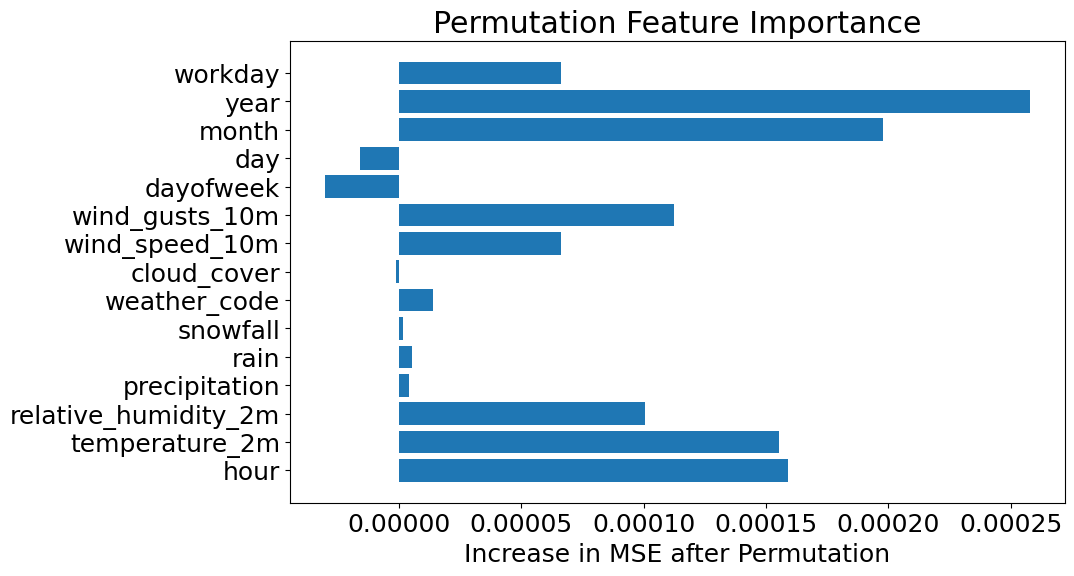

In [93]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to calculate permutation feature importance
def permutation_feature_importance(model, X_val, y_val, feature_names):
    baseline_mse = mean_squared_error(y_val, model.predict(X_val))
    importances = []

    for col in range(X_val.shape[2]):
        X_val_permuted = np.copy(X_val)
        np.random.shuffle(X_val_permuted[:, :, col])
        permuted_mse = mean_squared_error(y_val, model.predict(X_val_permuted))
        importances.append(permuted_mse - baseline_mse)

    return np.array(importances), feature_names

# Calculate feature importance
importances, feature_names = permutation_feature_importance(model, X_test, y_test, features.columns)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), feature_names)
plt.xlabel('Increase in MSE after Permutation')
plt.title('Permutation Feature Importance')
plt.show()

As shown in the above feature importance plot features like `year` and the generated moving averages are among the most important for predicting the dependent variable. 

## <span style="color:#2656a3;"> Hypertuning the last model</span>

Configure the Tuner and Set up the RandomSearch tuner with the hypermodel:



## <span style='color:#2656a3'>🗄 Model Registry</span>

The Model Registry in Hopsworks enable us to store the trained model. The model registry centralizes model management, enabling models to be securely accessed and governed. We can also save model metrics with the model, enabling the user to understand performance of the model on test (or unseen) data.

In [97]:
# Exporting the trained model to a directory
model_dir = "lstm_electricity_price_model"
print('Exporting trained model to: {}'.format(model_dir))

# Saving the model using TensorFlow's saved_model.save function
tf.saved_model.save(model, model_dir)

Exporting trained model to: lstm_electricity_price_model
INFO:tensorflow:Assets written to: lstm_electricity_price_model\assets
2024-05-23 21:39:39,841 INFO: Assets written to: lstm_electricity_price_model\assets


### <span style="color:#2656a3;">⚙️ Model Schema</span>
A model schema defines the structure and format of the input and output data that a machine learning model expects and produces, respectively. It serves as a **blueprint** for understanding how to interact with the model in terms of input features and output predictions. In the context of the Hopsworks platform, a model schema is typically defined using the Schema class, which specifies the features expected in the input data and the target variable in the output data. This schema helps ensure consistency and compatibility between the model and the data it operates on.

In [98]:
# Importing the libraries for saving the model
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

In [ ]:
# # Specify the schema of the model's input and output using the features (X_train) and dependent variable (y_train)
# input_schema = Schema(X_train)
# output_schema = Schema(y_train)

# # Create a model schema using the input and output schemas
# model_schema = ModelSchema(input_schema, output_schema)

In [99]:
# Retrieving the Model Registry
mr = project.get_model_registry()

# Extracting loss value from the training history
metrics = {'loss': history_dict['val_loss'][0]} 

# Creating a TensorFlow model in the Model Registry
tf_model = mr.tensorflow.create_model(
    name="lstm_electricity_price_model",
    metrics=metrics,
    #model_schema=model_schema,
    description="LSTM Daily electricity price prediction model.",
    #input_example=X_train[:1]
)

# Saving the model to the specified directory
tf_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/56 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/489079 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/747200 elapsed<00:00 remaining<?

RestAPIError: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/556180/dataset/upload/%2FProjects%2Fbenjami3%2FModels%2Flstm_electricity_price_model%2F1%5Cvariables). Server response: 
HTTP code: 400, HTTP reason: Invalid URI, body: b''

## <span style="color:#2656a3;">⏭️ **Next:** Part 04: Batch Inference </span>

Next notebook we will use the registered model to make predictions based on the batch data.